# Task 2

### Naive KNN

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pympler import asizeof


In [84]:
def distance(x1 , x2):
    dist = np.sqrt(np.sum((x1-x2)**2))
    return dist

In [100]:

class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        # Compute the distances
        distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
        
        if len(distances) == 0:
            raise ValueError("Training data is empty; cannot compute distances.")
        
        # Get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        print(k_nearest_labels)
        if not k_nearest_labels:
            raise ValueError("No neighbors found for the given test point.")

        # Majority vote
        label_counts = {}
        for label in k_nearest_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

        # Find the label with the highest count
        most_common_label = max(label_counts, key=label_counts.get)
        print("Most common label:", most_common_label)

        return k_indices


In [112]:
# Generate random data
np.random.seed(42)
X_train = np.random.randn(10, 2)
y_train = np.random.randint(0, 2, size=10)
X_test = np.array([[0.5, 0.5]])

X_train, y_train

(array([[ 0.49671415, -0.1382643 ],
        [ 0.64768854,  1.52302986],
        [-0.23415337, -0.23413696],
        [ 1.57921282,  0.76743473],
        [-0.46947439,  0.54256004],
        [-0.46341769, -0.46572975],
        [ 0.24196227, -1.91328024],
        [-1.72491783, -0.56228753],
        [-1.01283112,  0.31424733],
        [-0.90802408, -1.4123037 ]]),
 array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0], dtype=int32))

In [113]:
# Parameters
k = 3

# Naive KNN
naive_knn = KNN(k)
start_time = time.time()
naive_knn.fit(X_train, y_train)
y_hat = naive_knn.predict(X_test)[0]
test_time_naive = time.time() - start_time
knn_memory = asizeof.asizeof(naive_knn.fit(X_train, y_train)) + asizeof.asizeof(naive_knn.fit(X_train, y_train))
print("Naive KNN predictions:", y_hat)
print("Test time of Naive KNN -", test_time_naive)
print(f"Total memory used by Naive KNN: {knn_memory} bytes")


[np.int32(1), np.int32(0), np.int32(1)]
Most common label: 1
Naive KNN predictions: [0 4 1]
Test time of Naive KNN - 0.0006792545318603516
Total memory used by Naive KNN: 32 bytes


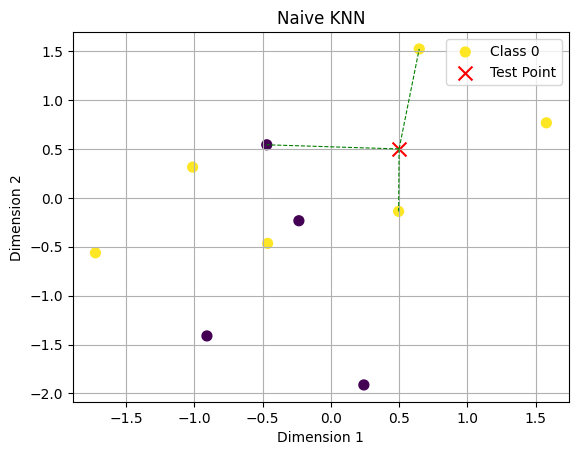

In [114]:

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=50, label="Class 0")
plt.scatter(X_test[0, 0], X_test[0, 1], color='red', label='Test Point', marker='x', s=100)
plt.legend()

# Plot naive KNN neighbors
for idx in y_hat:
    plt.plot([X_test[0, 0], X_train[idx, 0]], [X_test[0, 1], X_train[idx, 1]], 'g--', linewidth=0.8, label='Naive KNN Neighbor' if idx == y_hat[0] else "")

plt.title("Naive KNN")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()

### KD Tree KNN

In [122]:
from collections import Counter

class KDTree:
    def __init__(self, points, leaf_size):
        # Add an index column to the points for tracking original indices
        self.data_with_indices = np.hstack((points, np.arange(len(points)).reshape(-1, 1)))
        self.leaf_size = leaf_size
        self.tree = self._build_tree(self.data_with_indices)

    def _build_tree(self, data, depth=0):
        # If the number of points is less than or equal to leaf_size, create a leaf node
        if len(data) <= self.leaf_size:
            return data  # Leaf node

        # Determine the splitting axis
        axis = depth % (data.shape[1] - 1)  # Exclude the index column from splitting
        sorted_data = data[data[:, axis].argsort()]  # Sort data along the selected axis
        median_index = len(sorted_data) // 2

        # Recursively build left and right subtrees
        left_subtree = self._build_tree(sorted_data[:median_index], depth + 1)
        right_subtree = self._build_tree(sorted_data[median_index + 1:], depth + 1)

        # Return the current node as a tuple: (median point, left subtree, right subtree)
        return (sorted_data[median_index], left_subtree, right_subtree)

    def query(self, query_point, num_neighbors, y_train):
        indices, distances = self._query_recursive(self.tree, query_point, num_neighbors)
        # Retrieve the actual points corresponding to the indices
        nearest_points = self.data_with_indices[indices, :-1]
        nearest_labels = y_train[indices]  # Get labels for the nearest neighbors

        # Determine the most common label among the nearest neighbors
        label_counts = Counter(nearest_labels)
        most_common_label = label_counts.most_common(1)[0][0]

        return indices, nearest_points, distances, most_common_label

    def _query_recursive(self, node, query_point, num_neighbors, depth=0):
        if isinstance(node, np.ndarray):  # If the node is a leaf
            leaf_points = node[:, :-1]  # Extract points from the leaf
            original_indices = node[:, -1].astype(int)  # Extract original indices

            # Compute distances from the query point to all points in the leaf
            distances = np.linalg.norm(leaf_points - query_point, axis=1)
            # Sort distances and select the closest `num_neighbors`
            sorted_indices = np.argsort(distances)
            closest_indices = original_indices[sorted_indices[:num_neighbors]]
            closest_distances = distances[sorted_indices[:num_neighbors]]

            return closest_indices, closest_distances

        if isinstance(node, tuple) and len(node) == 3:  # If the node is an internal node
            median_point, left_subtree, right_subtree = node
            axis = depth % query_point.shape[0]  # Determine the splitting axis

            # Decide which subtree to explore first
            if query_point[axis] < median_point[axis]:
                primary_subtree, secondary_subtree = left_subtree, right_subtree
            else:
                primary_subtree, secondary_subtree = right_subtree, left_subtree

            # Search the primary subtree
            closest_indices, closest_distances = self._query_recursive(primary_subtree, query_point, num_neighbors, depth + 1)

            # Check if the secondary subtree might contain closer points
            if len(closest_indices) < num_neighbors or abs(query_point[axis] - median_point[axis]) < max(closest_distances):
                secondary_indices, secondary_distances = self._query_recursive(secondary_subtree, query_point, num_neighbors, depth + 1)

                # Combine results from both subtrees
                all_indices = np.concatenate([closest_indices, secondary_indices])
                all_distances = np.concatenate([closest_distances, secondary_distances])

                # Sort combined results by distance and select the closest `num_neighbors`
                sorted_combined = np.argsort(all_distances)
                closest_indices = all_indices[sorted_combined][:num_neighbors]
                closest_distances = all_distances[sorted_combined][:num_neighbors]
        
            return closest_indices, closest_distances

        # If the node is invalid, return empty arrays
        return np.array([]), np.array([])

In [123]:

start_time = time.time()
kdtree = KDTree(X_train, leaf_size=20)
train_time = time.time() - start_time

start_time = time.time()
indices, points, distances, most_common_label = kdtree.query(X_test[0], num_neighbors=3, y_train=y_train)
test_time = time.time() - start_time

train_memory = asizeof.asizeof(KDTree(X_train, leaf_size=20))
test_memory = asizeof.asizeof(kdtree.query(X_test[0], num_neighbors=3, y_train=y_train))
total_memory = train_memory + test_memory

print("Indices of nearest neighbors:", indices)
print("Nearest points:\n", points)
print("Most common label:", most_common_label)
print("Distances to nearest points:", distances)
print("Time taken to train:", train_time)
print(f"Total memory used by KDTree: {total_memory} bytes")


Indices of nearest neighbors: [0 4 1]
Nearest points:
 [[ 0.49671415 -0.1382643 ]
 [-0.46947439  0.54256004]
 [ 0.64768854  1.52302986]]
Most common label: 1
Distances to nearest points: [0.63827276 0.97040813 1.03363533]
Time taken to train: 0.000244140625
Total memory used by KDTree: 1520 bytes


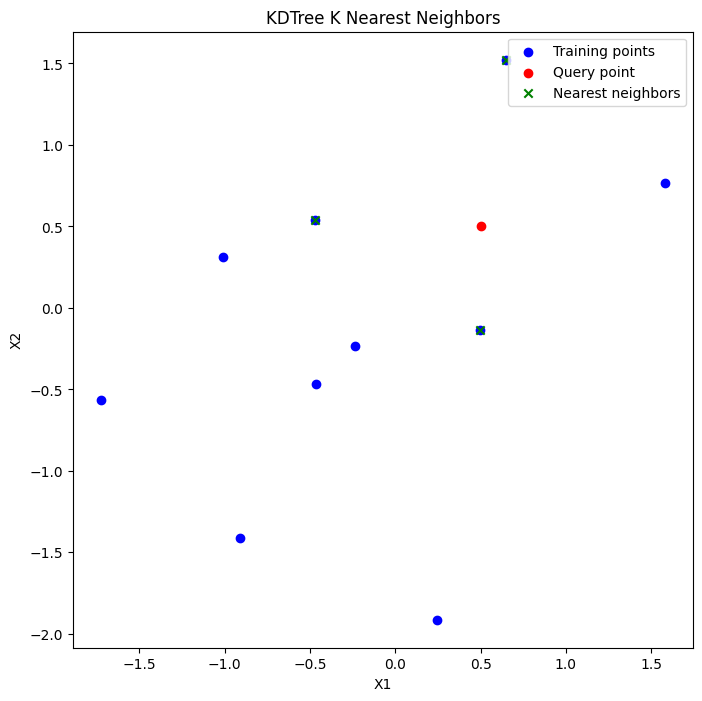

In [129]:
def visualize_kdtree(kdtree, query_point, num_neighbors, y_train):
    indices, nearest_points, distances, most_common_label = kdtree.query(query_point, num_neighbors, y_train)
    
    # Extract the original points from the KDTree
    X_train = kdtree.data_with_indices[:, :-1]
    
    # Plot the points
    plt.figure(figsize=(8, 8))
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training points')
    plt.scatter(query_point[0], query_point[1], c='red', label='Query point')
    plt.scatter(nearest_points[:, 0], nearest_points[:, 1], c='green', label='Nearest neighbors', marker='x')
    plt.title('KDTree K Nearest Neighbors')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    # Recursive function to plot partitions
    def plot_partitions(node, depth=0, bounds=None):
        if isinstance(node, tuple) and len(node) == 3:
            median_point, left_subtree, right_subtree = node
            axis = depth % 2  # Assuming 2D points for plotting

            # Initialize bounds if None
            if bounds is None:
                bounds = [[np.min(X_train[:, 0]), np.max(X_train[:, 0])],
                          [np.min(X_train[:, 1]), np.max(X_train[:, 1])]]

            # Draw splitting line based on the axis
            if axis == 0:  # Vertical line for X1
                plt.plot([median_point[0], median_point[0]], bounds[1], 'gray', linestyle='--', alpha=0.7)
                # Update bounds for subtrees
                left_bounds = [[bounds[0][0], median_point[0]], bounds[1]]
                right_bounds = [[median_point[0], bounds[0][1]], bounds[1]]
            else:  # Horizontal line for X2
                plt.plot(bounds[0], [median_point[1], median_point[1]], 'gray', linestyle='--', alpha=0.7)
                # Update bounds for subtrees
                left_bounds = [bounds[0], [bounds[1][0], median_point[1]]]
                right_bounds = [bounds[0], [median_point[1], bounds[1][1]]]

            # Recurse on left and right subtrees
            plot_partitions(left_subtree, depth + 1, left_bounds)
            plot_partitions(right_subtree, depth + 1, right_bounds)

    # Start plotting partitions from the root
    plot_partitions(kdtree.tree)
    
    plt.show()

visualize_kdtree(kdtree, X_test[0], num_neighbors=3, y_train=y_train)
